# Multi-class Classification

In [1]:
import os

import pandas as pd
import numpy as np

import scipy.io
import scipy.optimize as opt

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook', style='darkgrid')
%matplotlib inline

In [2]:
# Each pixel is represented by a floating point number indicating the grayscale intensity at that location.
# The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector.

PATH_TO_DATA = ''.join([os.getcwd(), '/data/ex3data1'])
data = scipy.io.loadmat(PATH_TO_DATA) # returns a dictionary

In [3]:
X = data['X']
y = data['y']
y = y.ravel()

## Visualisation of data

In [4]:
sample = np.random.choice(X.shape[0], 10)
sample

array([1259, 3296, 4839, 1044,  434, 2103,  596,  287, 4679, 3498])

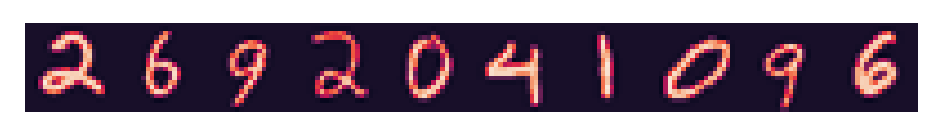

In [5]:
plt.matshow(X[sample].reshape(-1, 20).T)
plt.axis('off');

In [6]:
def sigmoid(z):
    return(1 / (1 + np.exp(-z)))

In [7]:
def compute_cost_regularised(theta, X, y, reg_lambda):
    predictions = sigmoid(np.dot(X, theta))
    errors = (-y * np.log(predictions)) - ((1 - y) * np.log(1 - predictions))
    reg_term = reg_lambda / (2 * m) * np.sum(np.power(theta[1:n], 2)) # theta_0 (bias) is intentionally excluded
    J = 1 / m * np.sum(errors) + reg_term
    return(J)

In [8]:
def compute_gradient_regularised(theta, X, y, reg_lambda):
    grad = np.zeros(n)
    predictions = sigmoid(np.dot(X, theta))
    errors = predictions - y
    grad = 1 / m * np.dot(X.T, errors) + ((reg_lambda / m) * theta)
    grad[0] = 1 / m * np.sum(errors * X[:,0]) # don't regularise the bias
    return(grad)

In [9]:
def predict(theta, X):
    threshold = 0.5
    probabilities = sigmoid(np.dot(X, theta.T))
    return([1 if probability >= threshold else 0 for probability in probabilities])

In [10]:
# Number of training examples
m = X.shape[0]

# Number of features
n = X.shape[1]

In [11]:
# Initialise fitting parameters (weights)
theta_initial = np.zeros(n)

print('theta_initial shape: {}'.format(theta_initial.shape))

theta_initial shape: (400,)


## One vs. All

In [12]:
def one_vs_all(X, y, num_labels, reg_lambda):
    all_theta = np.zeros((num_labels, n + 1))
    X = np.insert(X, 0, values=np.ones(m), axis=1) # Intercept term
    
    for i in range(1, num_labels + 1): # label 0 is 10
        theta = np.zeros(n + 1)
        y_i = np.array([1 if label == i else 0 for label in y])
        
        result = opt.minimize(fun=compute_cost_regularised,
                              x0=theta,
                              args=(X, y_i, reg_lambda),
                              method='TNC',
                              jac=compute_gradient_regularised,
                              options={'maxiter':50})
        all_theta[i - 1] = result.x
        
    return(all_theta)

In [13]:
all_theta = one_vs_all(X, y, 10, 0.1)
all_theta

array([[-3.60636682e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.94688858e-03,  1.74437938e-07,  0.00000000e+00],
       [-3.53260577e+00,  0.00000000e+00,  0.00000000e+00, ...,
         6.40784478e-03, -7.41667088e-04,  0.00000000e+00],
       [-5.30070558e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -5.56322711e-05, -1.54959515e-07,  0.00000000e+00],
       ...,
       [-9.01276759e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.43795025e-04,  1.13008389e-05,  0.00000000e+00],
       [-5.51011937e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.96795947e-03,  2.27722871e-04,  0.00000000e+00],
       [-7.77588211e+00,  0.00000000e+00,  0.00000000e+00, ...,
         5.23188963e-04,  2.62640273e-05,  0.00000000e+00]])

In [14]:
print("all_theta shape: {}".format(all_theta.shape))

all_theta shape: (10, 401)


In [15]:
# Add Intercept
X = np.insert(X, 0, values=np.ones(m), axis=1)

## Predict

In [16]:
def predict_one_vs_all(all_theta, X):
    probabilities = sigmoid(np.dot(X, all_theta.T))
    y_predicted = np.argmax(probabilities, axis=1) + 1
    return(y_predicted)

In [17]:
y_pred = predict_one_vs_all(all_theta, X)
y_pred

array([10, 10, 10, ...,  9,  9,  7])

In [18]:
print('Training set accuracy: {}%'.format(np.mean(y_pred == y) * 100))

Training set accuracy: 95.1%


# Neural Networks

## Feedforward Propagation and Prediction

In [23]:
np.set_printoptions(formatter={'float': '{: 0.5f}'.format})

In [19]:
X = data['X']
y = data['y']
y = y.ravel()

# Number of training examples
m = X.shape[0]

In [20]:
# Load some pre-initialized neural network parameters.
PATH_TO_DATA = ''.join([os.getcwd(), '/data/ex3weights'])
weights = scipy.io.loadmat(PATH_TO_DATA)

In [21]:
Theta1 = weights['Theta1']
Theta2 = weights['Theta2']

In [22]:
print("Theta1 shape: {}\nTheta2 shape: {}".format(Theta1.shape, Theta2.shape))

Theta1 shape: (25, 401)
Theta2 shape: (10, 26)


In [24]:
# Parameters
input_layer_size = 400 # 20 by 20 input images of digits
hidden_layer_size = 25 # 25 hidden units
num_labels = 10        # num_labels = Theta2[0]

In [25]:
def predict_nn(Theta1, Theta2, X):
    # Input layer (401 units, including the extra bias unit which always outputs +1)
    a1 = np.insert(X, 0, values=np.ones(m), axis=1) # a1 = X + intercept
    
    # Hidden layer (26 units, including the extra bias unit which always outputs +1)
    z2 = np.dot(Theta1, a1.T)                       # (25, 401) x (401, 5000)
    a2 = sigmoid(z2).T                              # (5000, 25)
    a2 = np.insert(a2, 0, 1, axis=1)                # (5000, 26)
    
    # Output layer (10 units)
    z3 = np.dot(a2, Theta2.T)                       # (5000, 26) x (26, 10)
    a3 = sigmoid(z3)                                # (5000, 10)
    
    y_predicted = np.argmax(a3, axis=1) + 1         # pick highest probability from each row corresponding to predicted digit
    return(y_predicted)

In [26]:
y_pred_nn = predict_nn(Theta1, Theta2, X)
y_pred_nn

array([10, 10, 10, ...,  9,  9,  9])

In [27]:
print('Training set accuracy: {}%'.format(np.mean(y_pred_nn == y) * 100))

Training set accuracy: 97.52%
